# Autoencoders in PyTorch

### Importing the Libraries

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### Enabling Device Agnostic execution

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


### Creating the transforms and loading the dataset into the dataloader

In [3]:
transform = transforms.ToTensor()

"""transforms = transforms.Compose(transforms=[
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))])"""

mnist_data = datasets.MNIST(root = './data', train = True, download = True, transform = transform)

data_loader = torch.utils.data.DataLoader(dataset = mnist_data,
                                         batch_size = 64,
                                         shuffle = True)

In [4]:
# First Analyse the value ranges and then choose the activation function
data_iter = iter(data_loader)
#images, labels = data_iter.next()
#print(torch.min(images), torch.max(images))

#print(data_iter)

## Building Autoencoders with PyTorch

### Autoencoders using Linear Layers

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self):
        # N(batch_size),784 (image resolution is 28*28)
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12,3)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,28*28),
            nn.Sigmoid() # To keep all the values in the range of 0 to 1 as given in the original images
        )
    
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Note: [-1,1] -> nn.Tanh()

In [6]:
model = AutoEncoder().to(device)
criterion = nn.MSELoss().to(device)
optim = Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [7]:
# Training Loop
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img,_) in data_loader:
        img = img.reshape(-1,28*28)
        img = img.to(device)
        recon = model(img)
        loss = criterion(recon,img)

        optim.zero_grad()
        loss.backward()
        optim.step()

    print(f'Epoch: {epoch+1}, Loss: {loss.item(): .4f}')
    outputs.append((epoch,img,recon))

Epoch: 1, Loss:  0.0460
Epoch: 2, Loss:  0.0450
Epoch: 3, Loss:  0.0424
Epoch: 4, Loss:  0.0375
Epoch: 5, Loss:  0.0427
Epoch: 6, Loss:  0.0354
Epoch: 7, Loss:  0.0387
Epoch: 8, Loss:  0.0427
Epoch: 9, Loss:  0.0375
Epoch: 10, Loss:  0.0353


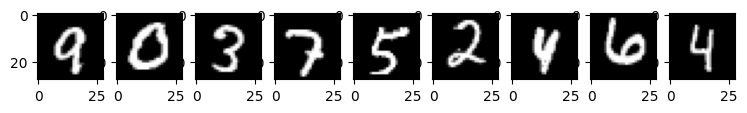

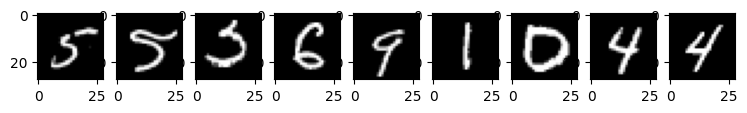

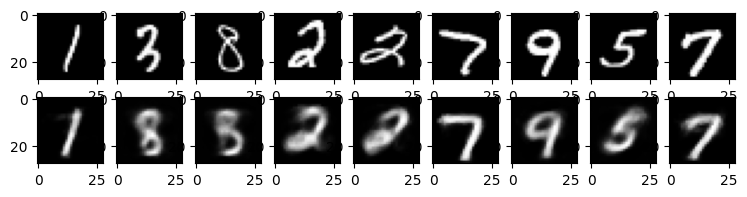

In [8]:
# Results
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().to("cpu").numpy()
    recon = outputs[k][2].detach().to("cpu").numpy()

    for i, item in enumerate (imgs):
        if i >= 9: break 
        plt. subplot (2, 9, i+1)
        item = item.reshape(-1, 28,28)
        # item: 1, 28, 28
        plt. imshow (item[0])

for i, item in enumerate (recon) :
    if i >= 9: break
    plt. subplot(2, 9, 9+i+1) # row_length + i + 1
    item = item.reshape (-1, 28,28)
    # item: 1, 28, 28
    plt. imshow (item[0])

### Autoencoders using Convolutional Layers

In [9]:
class CNNAutoEncoder(nn.Module):
    def __init__(self):
        # N(batch_size),(image resolution is 1*28*28)
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels=16, kernel_size=3, stride=2, padding=1), # N, 16, 14, 14 (Reduction in size = 50%)
            nn.ReLU(),
            nn.Conv2d(in_channels = 16, out_channels=32, kernel_size=3, stride=2, padding=1), # N, 32, 7, 7 (Reduction in size = 50% w.r.t above)
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels=64, kernel_size=7), # N, 64, 1, 1 
        )
        # N, 64, 1, 1 
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=7), # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32,out_channels=16,kernel_size=3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14
            # In the layer above, we perform zero padding on the output image by setting output_padding parameter to 1 else the output dimension would be N, 16, 13, 13
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16,out_channels=1,kernel_size=3,stride=2, padding=1, output_padding=1), # N, 1, 28, 28
            nn.Sigmoid() # To keep all the values in the range of 0 to 1 as given in the original images
        )
    
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Note: [-1,1] -> nn.Tanh()
# Note: nn.MaxPool2d -> nn.MaxPool2d is used to reduce the size of the images in the CNN architecture

In [10]:
model = CNNAutoEncoder().to(device)
criterion = nn.MSELoss().to(device)
optim = Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [12]:
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img,_) in data_loader:
        #img = img.reshape(-1,28*28)
        img = img.to(device)
        recon = model(img)
        loss = criterion(recon,img)

        optim.zero_grad()
        loss.backward()
        optim.step()

    print(f'Epoch: {epoch+1}, Loss: {loss.item(): .4f}')
    outputs.append((epoch,img,recon))

Epoch: 1, Loss:  0.0083
Epoch: 2, Loss:  0.0046
Epoch: 3, Loss:  0.0041
Epoch: 4, Loss:  0.0032
Epoch: 5, Loss:  0.0032
Epoch: 6, Loss:  0.0028
Epoch: 7, Loss:  0.0028
Epoch: 8, Loss:  0.0027
Epoch: 9, Loss:  0.0030
Epoch: 10, Loss:  0.0024


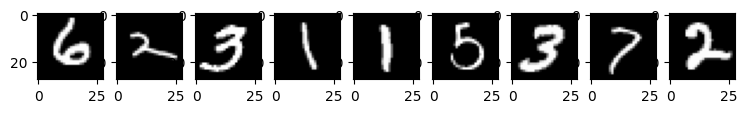

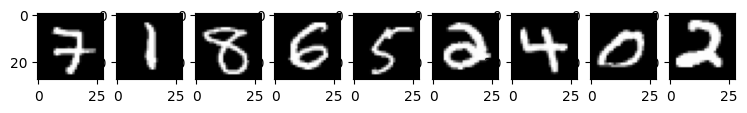

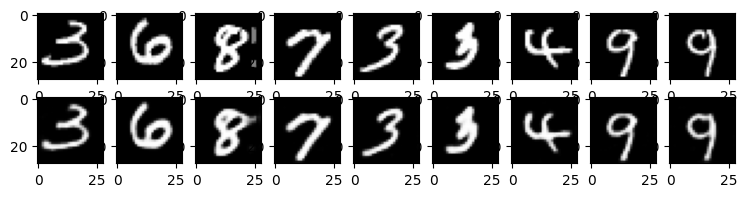

In [14]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().to("cpu").numpy()
    recon = outputs[k][2].detach().to("cpu").numpy()

    for i, item in enumerate (imgs):
        if i >= 9: break 
        plt. subplot (2, 9, i+1)
        #item = item.reshape(-1, 28,28)
        # item: 1, 28, 28
        plt. imshow (item[0])

for i, item in enumerate (recon) :
    if i >= 9: break
    plt. subplot(2, 9, 9+i+1) # row_length + i + 1
    #item = item.reshape (-1, 28,28)
    # item: 1, 28, 28
    plt. imshow (item[0])